In [17]:
# Cell 1: Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
 accuracy_score, precision_score, recall_score, f1_score,
 roc_auc_score, confusion_matrix, classification_report
 )
 # Import RandomUnderSampler for Step 4: Undersampling
from imblearn.under_sampling import RandomUnderSampler
import os
import warnings
warnings.filterwarnings('ignore')
print("="*80)
print("STEP 4: RANDOM UNDER SAMPLING (RUS)")
print("="*80)
print("\n✅ All libraries imported successfully!")

STEP 4: RANDOM UNDER SAMPLING (RUS)

✅ All libraries imported successfully!


In [19]:
# Cell 2: Load data from Step 1
X_train_scaled = np.load('../data/processed/X_train_scaled.npy')
X_test_scaled = np.load('../data/processed/X_test_scaled.npy')
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')
print(f"✅ Data loaded successfully!")
print(f"\nOriginal training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")
print(f"\nOriginal class distribution:")
print(f"  Malignant (0): {np.sum(y_train == 0)} samples ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  Benign (1): {np.sum(y_train == 1)} samples ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"  Imbalance ratio: {np.sum(y_train == 1) / np.sum(y_train == 0):.2f}:1")

✅ Data loaded successfully!

Original training data shape: (455, 30)
Test data shape: (114, 30)

Original class distribution:
  Malignant (0): 170 samples (37.4%)
  Benign (1): 285 samples (62.6%)
  Imbalance ratio: 1.68:1


In [20]:
# Cell 3: Apply Random Under Sampling
print("\n" + "="*60)
print("APPLYING RANDOM UNDER SAMPLING")
print("="*60)
# Initialize Random Under Sampler
rus = RandomUnderSampler(random_state=42)
# Apply under sampling to training data only
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)
print(f"\n✅ Random Under Sampling applied successfully!")
print(f"\nBalanced training data shape: {X_train_rus.shape}")
print(f"Balanced class distribution: {np.bincount(y_train_rus)}")
print(f"  Malignant (0): {np.sum(y_train_rus == 0)} samples")
print(f"  Benign (1): {np.sum(y_train_rus == 1)} samples")
print(f"  New balance ratio: {np.sum(y_train_rus == 1) / np.sum(y_train_rus == 0):.2f}:1")
# Calculate under sampling statistics
original_majority = np.sum(y_train == 1)
new_majority = np.sum(y_train_rus == 1)
removed_samples = original_majority - new_majority
print(f"\n Under Sampling Statistics:")
print(f"Original majority samples: {original_majority}")
print(f"New majority samples: {new_majority}")   
print(f"Samples removed: {removed_samples}")  
print(f"Total training samples: {len(y_train_rus)} (was {len(y_train)})")  
print(f"Data reduction: {(1 - len(y_train_rus)/len(y_train))*100:.1f}%")  

 
 
 


APPLYING RANDOM UNDER SAMPLING

✅ Random Under Sampling applied successfully!

Balanced training data shape: (340, 30)
Balanced class distribution: [170 170]
  Malignant (0): 170 samples
  Benign (1): 170 samples
  New balance ratio: 1.00:1

 Under Sampling Statistics:
Original majority samples: 285
New majority samples: 170
Samples removed: 115
Total training samples: 340 (was 455)
Data reduction: 25.3%


In [25]:
# Cell 4: Define comprehensive evaluation function
def evaluate_model_with_balancing(model, X_train, y_train, X_test, y_test, 
model_name, method_name):
     # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
                'Model': model_name,
        'Method': method_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1_Score': f1_score(y_test, y_pred, average='weighted'),
        'ROC_AUC': roc_auc_score(y_test, y_pred_proba),
        
        # Class-specific metrics (CRITICAL for imbalanced data)
        'Precision_Malignant': precision_score(y_test, y_pred, pos_label=0),
        'Recall_Malignant': recall_score(y_test, y_pred, pos_label=0),
        'F1_Malignant': f1_score(y_test, y_pred, pos_label=0),
        'Precision_Benign': precision_score(y_test, y_pred, pos_label=1),
        'Recall_Benign': recall_score(y_test, y_pred, pos_label=1),
        'F1_Benign': f1_score(y_test, y_pred, pos_label=1),
    }
    
    # Print results
    print(f"\n{'='*60}")
    print(f"Model: {model_name} | Method: {method_name}")
    print(f"{'='*60}")
    print(f"Overall: Acc={metrics['Accuracy']:.4f}, "
          f"F1={metrics['F1_Score']:.4f}, AUC={metrics['ROC_AUC']:.4f}")
    print(f"Malignant: P={metrics['Precision_Malignant']:.4f}, "
          f"R={metrics['Recall_Malignant']:.4f}, F1={metrics['F1_Malignant']:.4f}")
    print(f"Benign: P={metrics['Precision_Benign']:.4f}, "
          f"R={metrics['Recall_Benign']:.4f}, F1={metrics['F1_Benign']:.4f}")
    
    return metrics, y_pred, y_pred_proba



print("✅ Evaluation function defined successfully!")

✅ Evaluation function defined successfully!


In [30]:
# Cell 5: Train all models with RUS-balanced data
models = {
 'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs'),
 'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5),
 'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
 }
rus_results = []
rus_predictions = {}  # Store predictions for confusion matrix
print("\n" + "="*80)
print("TRAINING MODELS WITH RUS-BALANCED DATA")
print("="*80)
for name, model in models.items():
    print(f"\n Training {name}...")
    metrics, y_pred, y_pred_proba = evaluate_model_with_balancing(
    model, X_train_rus, y_train_rus, X_test_scaled, y_test,
    name, "RUS"
    )
    rus_results.append(metrics)
    rus_predictions[name] = y_pred  # Save predictions

 # Create results DataFrame 
rus_results_df = pd.DataFrame(rus_results) 
print("\n" + "="*80)
print("RUS MODELS COMPARISON")
print("="*80)
print(rus_results_df[['Model', 'Accuracy', 'F1_Score', 'ROC_AUC', 
                      'Recall_Malignant', 'F1_Malignant']].to_string(index=False))



TRAINING MODELS WITH RUS-BALANCED DATA

 Training Logistic Regression...

Model: Logistic Regression | Method: RUS
Overall: Acc=0.9561, F1=0.9564, AUC=0.9940
Malignant: P=0.9111, R=0.9762, F1=0.9425
Benign: P=0.9855, R=0.9444, F1=0.9645

 Training Decision Tree...

Model: Decision Tree | Method: RUS
Overall: Acc=0.9561, F1=0.9560, AUC=0.9479
Malignant: P=0.9512, R=0.9286, F1=0.9398
Benign: P=0.9589, R=0.9722, F1=0.9655

 Training Random Forest...

Model: Random Forest | Method: RUS
Overall: Acc=0.9386, F1=0.9390, AUC=0.9954
Malignant: P=0.8889, R=0.9524, F1=0.9195
Benign: P=0.9710, R=0.9306, F1=0.9504

RUS MODELS COMPARISON
              Model  Accuracy  F1_Score  ROC_AUC  Recall_Malignant  F1_Malignant
Logistic Regression  0.956140  0.956430 0.994048          0.976190      0.942529
      Decision Tree  0.956140  0.956027 0.947917          0.928571      0.939759
      Random Forest  0.938596  0.939002 0.995370          0.952381      0.919540


In [33]:
# Cell 6: Load baseline and SMOTE results for comparison
import pandas as pd

baseline_results = pd.read_csv('../results/baseline_results.csv')
smote_results = pd.read_csv('../results/smote_results.csv')
rus_results_df = pd.read_csv('../results/rus_results.csv')

print("\n" + "="*80)
print("COMPARISON: BASELINE vs SMOTE vs RUS")
print("="*80)

comparison_metrics = ['Accuracy', 'F1_Score', 'ROC_AUC', 'Recall_Malignant', 'F1_Malignant']

for model_name in ['Logistic Regression', 'Decision Tree', 'Random Forest']:
    print(f"\n{'='*70}")
    print(f"MODEL: {model_name}")
    print(f"{'='*70}")

    # Get the row for this model from each DataFrame
    baseline_row = baseline_results[baseline_results['Model'] == model_name].iloc[0]
    smote_row = smote_results[smote_results['Model'] == model_name].iloc[0]
    rus_row = rus_results_df[rus_results_df['Model'] == model_name].iloc[0]
    
    # Print column headers
    print(f"\n{'Metric':<20} {'Baseline':<12} {'SMOTE':<12} {'RUS':<12} {'Best Method'}")
    print("-" * 70)

    for metric in comparison_metrics:
        # Handle case if some CSVs use e.g. 'F1_Class_0' instead of 'F1_Malignant'
        metric_baseline = metric if metric in baseline_row else metric.replace('_Malignant', '_Class_0')
        
        baseline_val = baseline_row[metric_baseline]
        smote_val = smote_row[metric]
        rus_val = rus_row[metric]
        
        # Determine best method for this metric
        best_method = max(
            [('Baseline', baseline_val), ('SMOTE', smote_val), ('RUS', rus_val)],
            key=lambda x: x[1]
        )[0]
        print(f"{metric:<20} {baseline_val:<12.4f} {smote_val:<12.4f} {rus_val:<12.4f} {best_method}")



COMPARISON: BASELINE vs SMOTE vs RUS

MODEL: Logistic Regression

Metric               Baseline     SMOTE        RUS          Best Method
----------------------------------------------------------------------
Accuracy             0.9825       0.9561       0.9561       Baseline
F1_Score             0.9825       0.9564       0.9564       Baseline
ROC_AUC              0.9954       0.9940       0.9940       Baseline
Recall_Malignant     0.9762       0.9762       0.9762       Baseline
F1_Malignant         0.9762       0.9425       0.9425       Baseline

MODEL: Decision Tree

Metric               Baseline     SMOTE        RUS          Best Method
----------------------------------------------------------------------
Accuracy             0.9035       0.9561       0.9561       SMOTE
F1_Score             0.9045       0.9560       0.9560       SMOTE
ROC_AUC              0.9216       0.9504       0.9504       SMOTE
Recall_Malignant     0.9286       0.9286       0.9286       Baseline
F1_Malignant

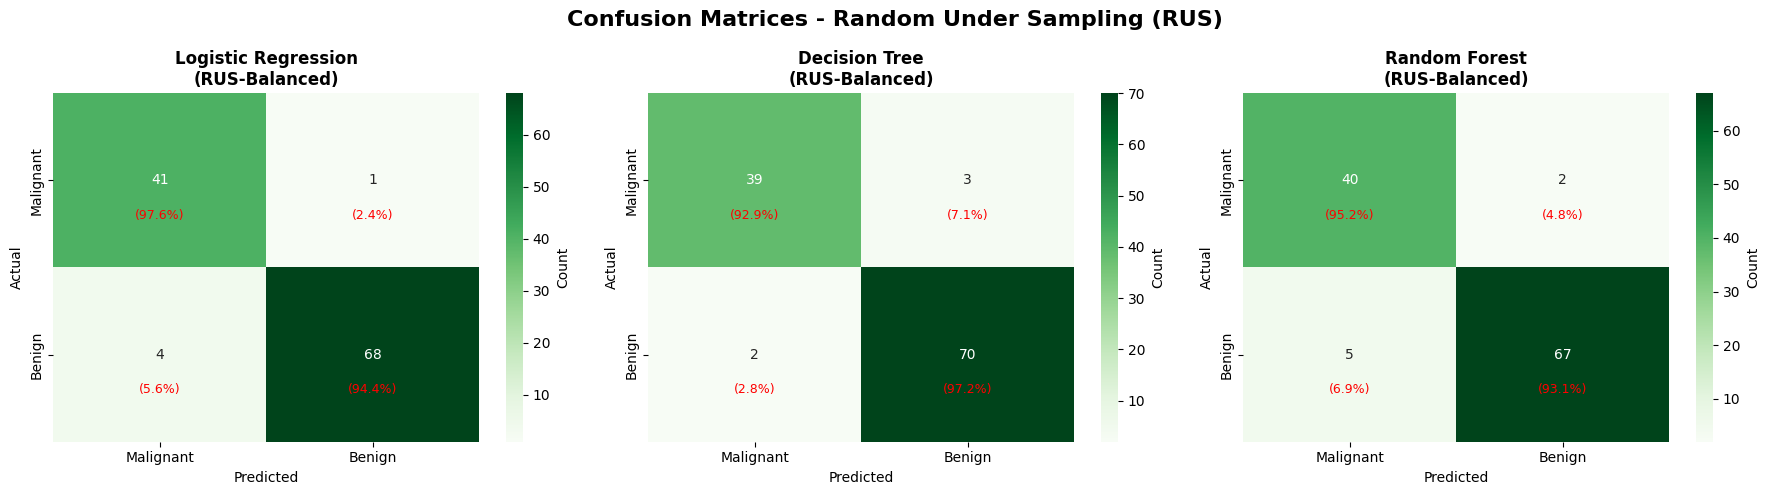


✅ Confusion matrices saved to: ../reports/figures/rus_confusion_matrices.png


In [34]:
# Cell 7: Visualize confusion matrices for RUS
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
class_names = ['Malignant', 'Benign']
for i, (name, y_pred) in enumerate(rus_predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i],
                xticklabels=class_names, yticklabels=class_names,
                cmap='Greens', cbar_kws={'label': 'Count'})
    
    axes[i].set_title(f'{name}\n(RUS-Balanced)', fontweight='bold')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    
    # Add percentages
    for j in range(2):
        for k in range(2):
            axes[i].text(k+0.5, j+0.7, f'({cm_normalized[j,k]:.1f}%)',
                        ha='center', va='center', fontsize=9, color='red')
plt.suptitle('Confusion Matrices - Random Under Sampling (RUS)', fontsize=16, fontweight='bold')
plt.tight_layout()
 # Save figure
os.makedirs('../reports/figures', exist_ok=True)
plt.savefig('../reports/figures/rus_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✅ Confusion matrices saved to: ../reports/figures/rus_confusion_matrices.png")

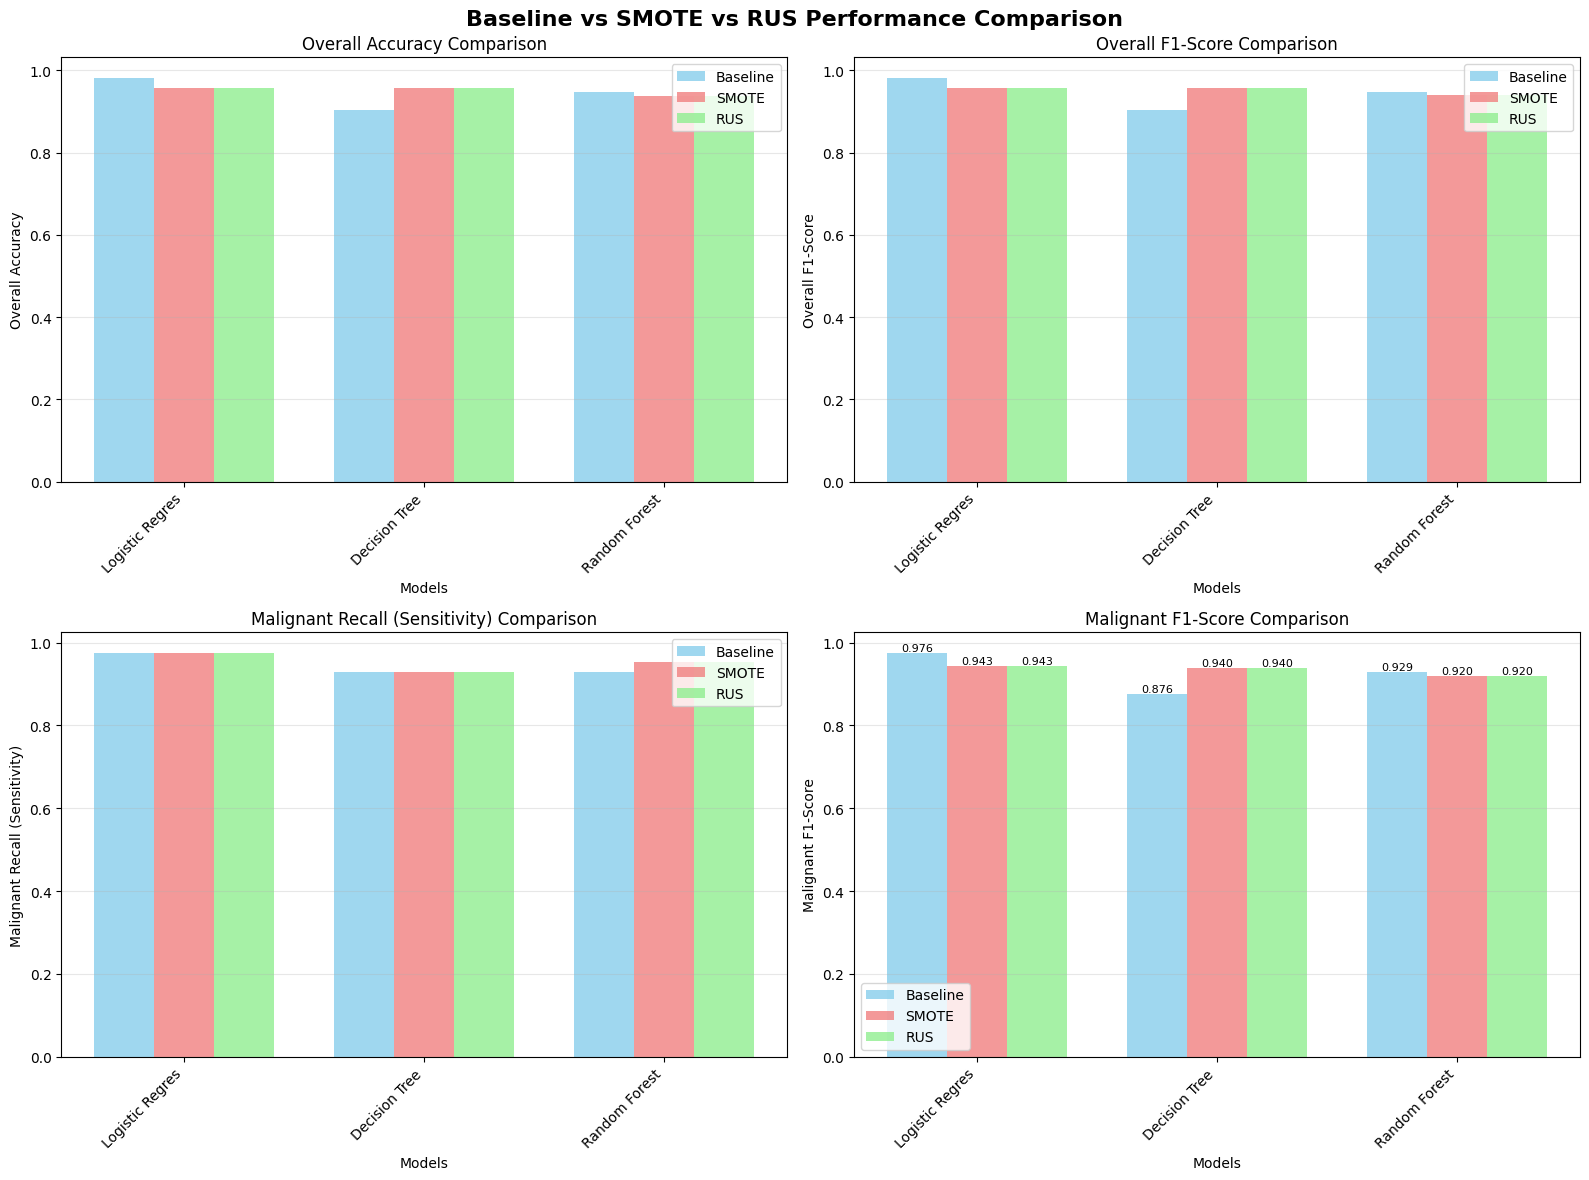


✅ Performance comparison saved to: ../reports/figures/rus_performance_comparison.png


In [36]:
# Cell 8: Visualize performance improvements across methods
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics_to_plot = [
    ('Accuracy', 'Overall Accuracy'),
    ('F1_Score', 'Overall F1-Score'),
    ('Recall_Malignant', 'Malignant Recall (Sensitivity)'),
    ('F1_Malignant', 'Malignant F1-Score')
 ]
for idx, (metric, title) in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    model_names = list(models.keys())
    baseline_vals = []
    smote_vals = []
    rus_vals = []
    
    for model_name in model_names:
        metric_col = metric.replace('_Malignant', '_Class_0') if 'Malignant' in metric else metric
        
        baseline_val = baseline_results[baseline_results['Model'] == model_name][metric_col].values[0]
        smote_val = smote_results[smote_results['Model'] == model_name][metric].values[0]
        rus_val = rus_results_df[rus_results_df['Model'] == model_name][metric].values[0]
        
        baseline_vals.append(baseline_val)
        smote_vals.append(smote_val)
        rus_vals.append(rus_val)
    
    x = np.arange(len(model_names))
    width = 0.25
    
    bars1 = ax.bar(x - width, baseline_vals, width, label='Baseline', 
                   color='skyblue', alpha=0.8)
    bars2 = ax.bar(x, smote_vals, width, label='SMOTE', 
                   color='lightcoral', alpha=0.8)
    bars3 = ax.bar(x + width, rus_vals, width, label='RUS', 
                   color='lightgreen', alpha=0.8)
    
    ax.set_xlabel('Models')
    ax.set_ylabel(title)
    ax.set_title(f'{title} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels([name[:15] for name in model_names], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
 # Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)
plt.suptitle('Baseline vs SMOTE vs RUS Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/rus_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✅ Performance comparison saved to: ../reports/figures/rus_performance_comparison.png")

In [37]:
 # Cell 9: Save RUS results
os.makedirs('../results', exist_ok=True)
rus_results_df.to_csv('../results/rus_results.csv', index=False)
print("\n" + "="*80)
print("STEP 4 COMPLETED SUCCESSFULLY!")
print("="*80)
print("\n✅ RUS results saved to: ../results/rus_results.csv")
print("\n Generated Files:")
print("   - ../results/rus_results.csv")
print("   - ../reports/figures/rus_performance_comparison.png")
print("   - ../reports/figures/rus_confusion_matrices.png")
print("\n Key Findings:")
best_model = rus_results_df.loc[rus_results_df['F1_Malignant'].idxmax()]
print(f"Best model for RUS: {best_model['Model']}")
print(f"Malignant F1-Score: {best_model['F1_Malignant']:.4f}")  
print(f"Malignant Recall: {best_model['Recall_Malignant']:.4f}") 
print(f"Overall Accuracy: {best_model['Accuracy']:.4f}")  

 
 


STEP 4 COMPLETED SUCCESSFULLY!

✅ RUS results saved to: ../results/rus_results.csv

 Generated Files:
   - ../results/rus_results.csv
   - ../reports/figures/rus_performance_comparison.png
   - ../reports/figures/rus_confusion_matrices.png

 Key Findings:
Best model for RUS: Logistic Regression
Malignant F1-Score: 0.9425
Malignant Recall: 0.9762
Overall Accuracy: 0.9561
